In [52]:
import import_ipynb
import advanced
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import MCXGate
from qiskit.quantum_info import partial_trace, Statevector, DensityMatrix
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.visualization import plot_distribution
import numpy as np

In [53]:
# Our problem is a 2×2 binary sudoku, which in our case has two simple rules:
#   No column may contain the same value twice
#   No row may contain the same value twice


def sub():
    qreg = QuantumRegister(4)
    areg = QuantumRegister(4)
    qc = QuantumCircuit(qreg, areg, name="U$_o$")
    qc.cx(qreg[0], areg[0])
    qc.cx(qreg[1], areg[0])
    qc.cx(qreg[0], areg[1])
    qc.cx(qreg[2], areg[1])
    qc.cx(qreg[1], areg[2])
    qc.cx(qreg[3], areg[2])
    qc.cx(qreg[2], areg[3])
    qc.cx(qreg[3], areg[3])
    return qc


def oracle():

    qreg = QuantumRegister(4)
    areg = QuantumRegister(4)
    oreg = QuantumRegister(1)
    qc = QuantumCircuit(qreg, areg, oreg, name="U$_w$")

    qc.compose(sub(), inplace=True)
    U = MCXGate(4, ctrl_state="1111")
    qc.compose(U, qubits=[*areg, *oreg], inplace=True)
    qc.compose(sub().inverse(), inplace=True)

    return qc


def Sudoku():
    qubits = 4
    ancilla = 4
    output = 1

    qreg = QuantumRegister(qubits)
    areg = QuantumRegister(ancilla)
    oreg = QuantumRegister(output)
    creg = ClassicalRegister(qubits)
    qc = QuantumCircuit(qreg, areg, oreg, creg)

    qc.h(qreg)

    # related to the constraints
    qc.x(oreg)
    qc.h(oreg)

    # unknown number of iterations (bruteforce)
    for _ in range(2):
        # sv = Statevector(qc) -> R = 1
        # pt = partial_trace(sv, list(range(8, 3, -1)))
        qc.compose(oracle(), inplace=True)
        # U = (2 * pt - np.eye(2 ** qubits)).to_operator()
        # qc.append(U, qreg)
        qc.compose(advanced.diffuser(qubits), inplace=True)

    qc.measure(qreg, creg)

    return qc

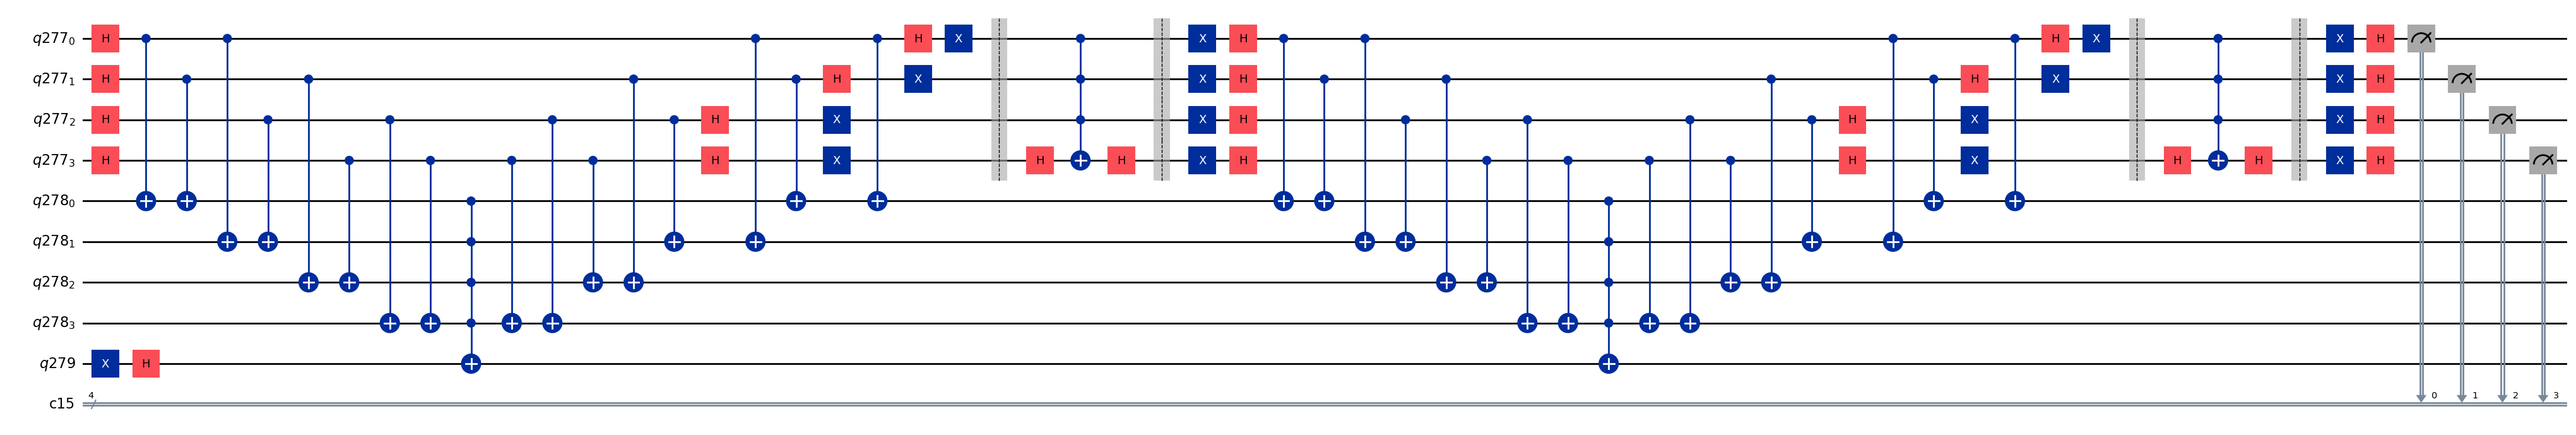

In [54]:
qc = Sudoku()
qc.draw("mpl", fold=-1)

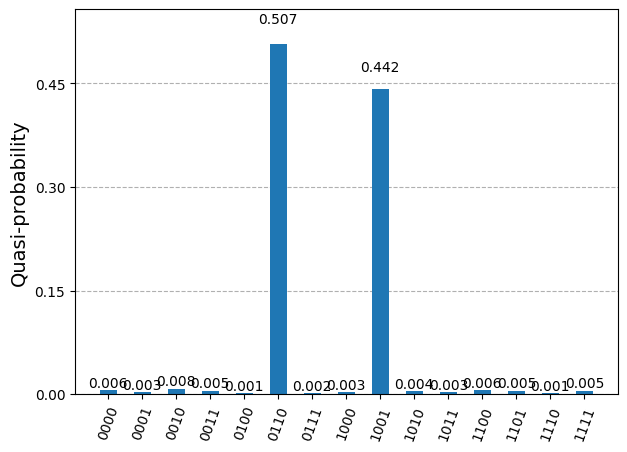

In [55]:
shots = 1024
simulator = AerSimulator()
qc = transpile(qc, simulator)
job = simulator.run(qc)
counts = job.result().get_counts(qc)
plot_distribution(counts)